# Construct Labels Dataframe from Label files

In [2]:
# Mount a folder from google drive
from google.colab import drive
drive.mount('/content/drive')

# Set the labels folder to /drive/MyDrive/IoT/park_ic2_labels
labels_folder = "/content/drive/MyDrive/IoT/park_ic2_labels"

## (TESTING) Label Extraction for a single image


In [3]:
import os

label_filename = "original_1653418628152.txt"
label_filepath = os.path.join(labels_folder, label_filename)

with open(label_filepath, 'r') as f:
    label_content = f.read()

print(label_content)

2 0.5998756289482117 0.589328408241272 0.1289600431919098 0.2244379073381424
2 0.7017163634300232 0.5995787978172302 0.14061394333839417 0.259735107421875
2 0.7936223149299622 0.6064855456352234 0.12495994567871094 0.19089460372924805
2 0.26237648725509644 0.5110651850700378 0.15810275077819824 0.20063666999340057
2 0.8456058502197266 0.6028231978416443 0.10152015835046768 0.18793641030788422
2 0.7673835754394531 0.390036940574646 0.07774944603443146 0.07274337112903595
2 0.5505310893058777 0.33286333084106445 0.05025062710046768 0.05790586397051811
2 0.493262380361557 0.3204610049724579 0.0497346892952919 0.061988163739442825
2 0.44156408309936523 0.31185150146484375 0.05321807786822319 0.06133890151977539
2 0.3745724856853485 0.24192547798156738 0.06157956272363663 0.026888132095336914
2 0.031709250062704086 0.3251194953918457 0.0632321685552597 0.05103640630841255
2 0.6524718403816223 0.35889679193496704 0.07108230888843536 0.0626835823059082
2 0.22263455390930176 0.2494206726551056

In [4]:
# Parse the label file content
boxes_info = []
for line in label_content.strip().split('\n'):
    if line:
        parts = line.split()
        class_id = int(parts[0])
        # YOLO format: center_x, center_y, width, height (normalized)
        center_x = float(parts[1])
        center_y = float(parts[2])
        width = float(parts[3])
        height = float(parts[4])
        boxes_info.append({
            'class_id': class_id,
            'center_x': center_x,
            'center_y': center_y,
            'width': width,
            'height': height
        })

print("Extracted box information:")
for box in boxes_info:
    print(box)

Extracted box information:
{'class_id': 2, 'center_x': 0.5998756289482117, 'center_y': 0.589328408241272, 'width': 0.1289600431919098, 'height': 0.2244379073381424}
{'class_id': 2, 'center_x': 0.7017163634300232, 'center_y': 0.5995787978172302, 'width': 0.14061394333839417, 'height': 0.259735107421875}
{'class_id': 2, 'center_x': 0.7936223149299622, 'center_y': 0.6064855456352234, 'width': 0.12495994567871094, 'height': 0.19089460372924805}
{'class_id': 2, 'center_x': 0.26237648725509644, 'center_y': 0.5110651850700378, 'width': 0.15810275077819824, 'height': 0.20063666999340057}
{'class_id': 2, 'center_x': 0.8456058502197266, 'center_y': 0.6028231978416443, 'width': 0.10152015835046768, 'height': 0.18793641030788422}
{'class_id': 2, 'center_x': 0.7673835754394531, 'center_y': 0.390036940574646, 'width': 0.07774944603443146, 'height': 0.07274337112903595}
{'class_id': 2, 'center_x': 0.5505310893058777, 'center_y': 0.33286333084106445, 'width': 0.05025062710046768, 'height': 0.057905863

In [7]:
import numpy as np
from PIL import Image

# Load the mask image
mask_filepath = '/content/mask_original_img_768_1024_bw.png'
try:
    mask_image = Image.open(mask_filepath)
    # Convert mask to numpy array
    mask = np.array(mask_image)
    print(f"Mask image loaded successfully from '{mask_filepath}'.")
except FileNotFoundError:
    print(f"Error: Mask file not found at '{mask_filepath}'")
except Exception as e:
    print(f"An error occurred while loading the mask image: {e}")


def detection_matrix_modified(x,y,mask):
    mask = mask[:,:,0]
    # print(mask.shape)
    mask_h, mask_w = mask.shape
    # mask_x,mask_y = mask.shape[:2]
    # mask_x, mask_y = (480,640)
    x = x*mask_w
    y = y*mask_h
    x_idx = int(np.clip(x, 0, mask_w - 1))
    y_idx = int(np.clip(y, 0, mask_h - 1))
    pixel_value = mask[int(y_idx),int(x_idx)]
    # print(f"\n points are {x},{y} \n pixel value: {pixel_value} and mask shape is {mask.shape}\n mask_x = {mask_x}, mask_y = {mask_y}")
    if pixel_value == 255:
        # print("The point is outside the mask.")
        return False
    else:
        # print("The point is inside the mask.")
        return True

def count_cars_post(lines, mask,class_names_dict=0):

    car_count = 0
    truck_count = 0

    for line in lines:

        line_ = np.array(line)
        x_center, y_center, width, height = line_

        point_inside = detection_matrix_modified(x_center,y_center,mask)
        # print(f"\n\n\n\n point {x_center}, {y_center} is {point_inside} ")
        if point_inside == True:

            car_count += 1

    return car_count + truck_count


# Filter boxes_info using the provided functions and mask
filtered_boxes_info = []
for box in boxes_info:
    # Extract normalized center coordinates
    x_center = box['center_x']
    y_center = box['center_y']

    # Check if the center of the box is inside the mask
    if detection_matrix_modified(x_center, y_center, mask):
        filtered_boxes_info.append(box)

print("\nFiltered box information (centers inside mask):")
for box in filtered_boxes_info:
    print(box)

print(f"\nOriginal number of boxes: {len(boxes_info)}")
print(f"Number of filtered boxes: {len(filtered_boxes_info)}")

# You can optionally update boxes_info to the filtered list if you want to use it for subsequent steps
# boxes_info = filtered_boxes_info

Mask image loaded successfully from '/content/mask_original_img_768_1024_bw.png'.

Filtered box information (centers inside mask):
{'class_id': 2, 'center_x': 0.5998756289482117, 'center_y': 0.589328408241272, 'width': 0.1289600431919098, 'height': 0.2244379073381424}
{'class_id': 2, 'center_x': 0.7017163634300232, 'center_y': 0.5995787978172302, 'width': 0.14061394333839417, 'height': 0.259735107421875}
{'class_id': 2, 'center_x': 0.7936223149299622, 'center_y': 0.6064855456352234, 'width': 0.12495994567871094, 'height': 0.19089460372924805}
{'class_id': 2, 'center_x': 0.26237648725509644, 'center_y': 0.5110651850700378, 'width': 0.15810275077819824, 'height': 0.20063666999340057}
{'class_id': 2, 'center_x': 0.8456058502197266, 'center_y': 0.6028231978416443, 'width': 0.10152015835046768, 'height': 0.18793641030788422}
{'class_id': 2, 'center_x': 0.7673835754394531, 'center_y': 0.390036940574646, 'width': 0.07774944603443146, 'height': 0.07274337112903595}
{'class_id': 2, 'center_x': 

### (TESTING) Load the image

In [12]:
from PIL import Image

image_filename = "original_1653418628152.jpg"
image_filepath = os.path.join('/content', image_filename) # Assuming the image is in the /content directory

try:
    image = Image.open(image_filepath)
    print(f"Image '{image_filename}' loaded successfully.")
    print(f"Image size: {image.size}")
except FileNotFoundError:
    print(f"Error: Image file not found at '{image_filepath}'")
except Exception as e:
    print(f"An error occurred while loading the image: {e}")

Image 'original_1653418628152.jpg' loaded successfully.
Image size: (1024, 768)


### (TESTING) Display the image

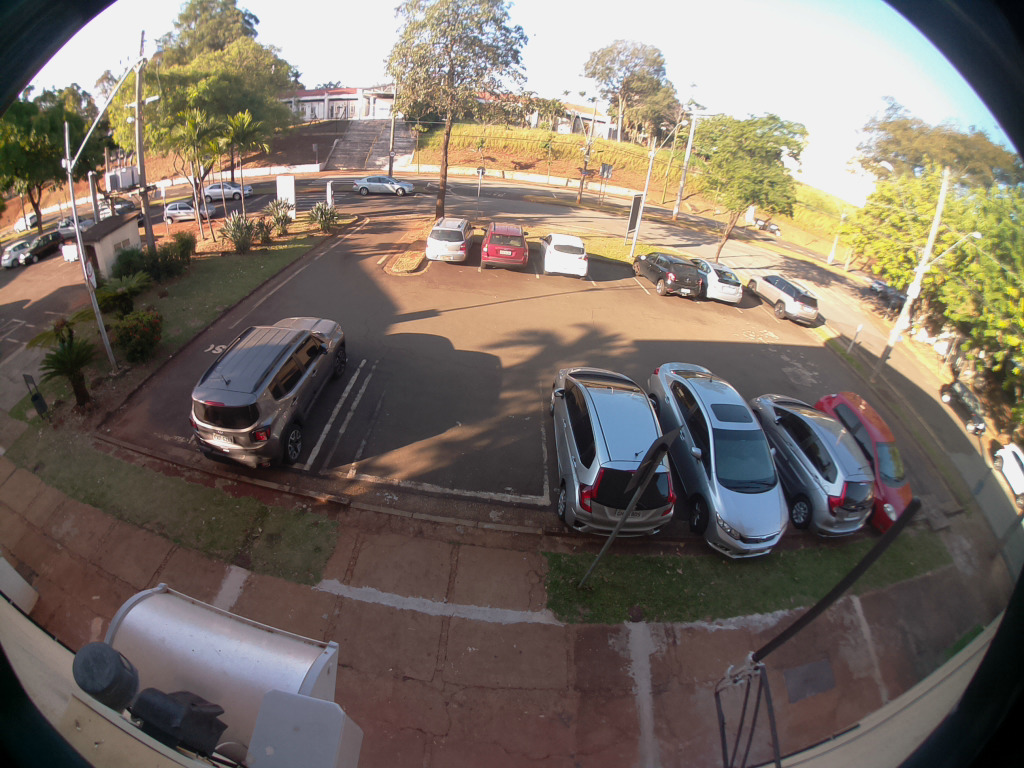

In [13]:
from IPython.display import display

display(image)

In [14]:
from PIL import ImageDraw

# Create a drawing object
draw = ImageDraw.Draw(image)

# Get image dimensions
image_width, image_height = image.size

# Draw each bounding box
for box in filtered_boxes_info:
    # Convert normalized YOLO coordinates to pixel coordinates (x1, y1, x2, y2)
    center_x = box['center_x'] * image_width
    center_y = box['center_y'] * image_height
    width = box['width'] * image_width
    height = box['height'] * image_height

    x1 = center_x - width / 2
    y1 = center_y - height / 2
    x2 = center_x + width / 2
    y2 = center_y + height / 2

    # Draw the rectangle
    draw.rectangle([(x1, y1), (x2, y2)], outline="red", width=2)

print("Bounding boxes drawn on the image.")

Bounding boxes drawn on the image.


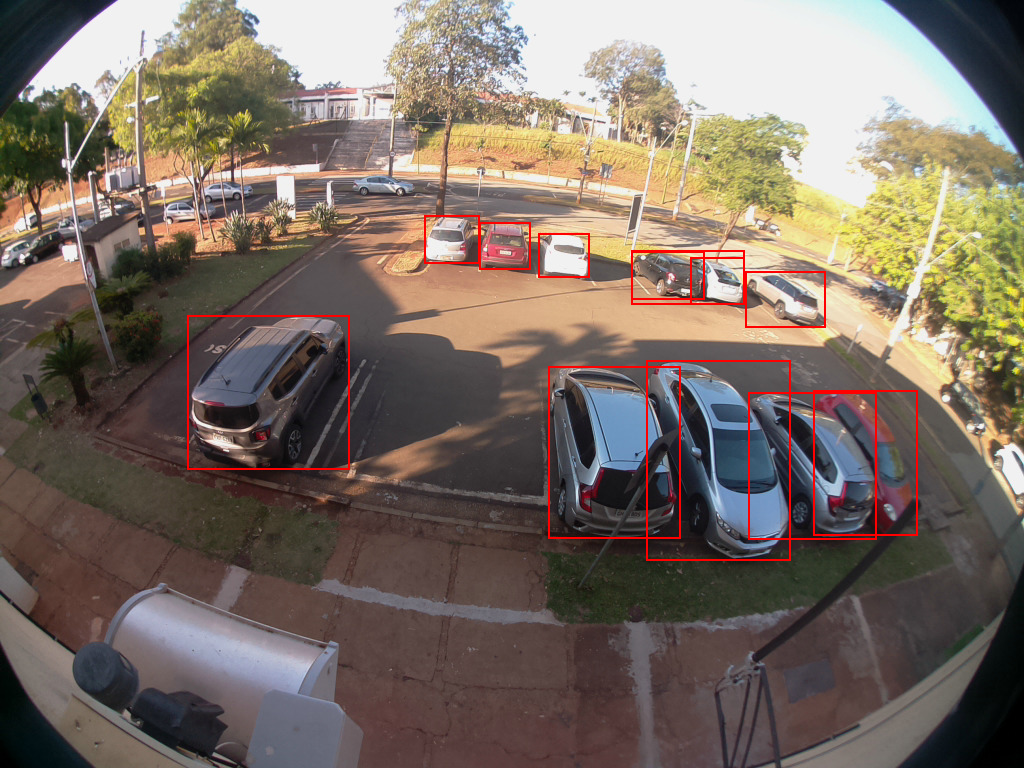

In [15]:
from IPython.display import display

display(image)

## Generate Labels Dataset

In [16]:
import os
import pandas as pd
import numpy as np
from PIL import Image

# Load the mask image (assuming it's already loaded in the environment from previous steps)
# If not, you would need to load it here:
mask_filepath = '/content/mask_original_img_768_1024_bw.png'
try:
    mask_image = Image.open(mask_filepath)
    mask = np.array(mask_image)
    print(f"Mask image loaded successfully from '{mask_filepath}'.")
except FileNotFoundError:
    print(f"Error: Mask file not found at '{mask_filepath}'")
except Exception as e:
    print(f"An error occurred while loading the mask image: {e}")

# Define the detection_matrix_modified function (assuming it's already defined in previous steps)
# If not, you would need to define it here:
def detection_matrix_modified(x,y,mask):
    mask = mask[:,:,0]
    mask_h, mask_w = mask.shape
    x = x*mask_w
    y = y*mask_h
    x_idx = int(np.clip(x, 0, mask_w - 1))
    y_idx = int(np.clip(y, 0, mask_h - 1))
    pixel_value = mask[int(y_idx),int(x_idx)]
    if pixel_value == 255:
        return False
    else:
        return True

# Parse file content and extract boxes
def parse_file_content(label_content):
  boxes_info = []
  for line in label_content.strip().split('\n'):
      if line:
          parts = line.split()
          class_id = int(parts[0])
          # YOLO format: center_x, center_y, width, height (normalized)
          center_x = float(parts[1])
          center_y = float(parts[2])
          width = float(parts[3])
          height = float(parts[4])
          boxes_info.append({
              'class_id': class_id,
              'center_x': center_x,
              'center_y': center_y,
              'width': width,
              'height': height
          })
  return boxes_info

# List to store the results
results_list = []

# Iterate through all files in the labels_folder
for label_filename in os.listdir(labels_folder):
    if label_filename.endswith(".txt"): # Process only text files
        label_filepath = os.path.join(labels_folder, label_filename)
        image_filename = label_filename.replace(".txt", ".jpg") # Assuming corresponding image is .jpg

        try:
            with open(label_filepath, 'r') as f:
                label_content = f.read()

            # Parse the label file content and filter boxes
            filtered_boxes_count = 0
            boxes_info = parse_file_content(label_content)
            for box in boxes_info:
              if detection_matrix_modified(box['center_x'], box['center_y'], mask):
                filtered_boxes_count += 1

            # Append the results to the list
            results_list.append({'image_name': image_filename, 'box_count': filtered_boxes_count})

        except Exception as e:
            print(f"Error processing file {label_filename}: {e}")

# Create a pandas DataFrame from the results list
labels_df = pd.DataFrame(results_list)

# Display the resulting DataFrame
display(labels_df.head())

Mask image loaded successfully from '/content/mask_original_img_768_1024_bw.png'.


image_name  box_count
0  original_1653441640969.jpg          2
1  original_1654641379012.jpg          2
2  original_1654279838176.jpg          4
3  original_1654283585868.jpg          3
4  original_1654294657068.jpg          2

In [17]:
# Save labels_df as a .csv
labels_df.to_csv('labels.csv', index=False)

In [18]:
# Load labels_df from .csv
labels_df = pd.read_csv('labels.csv')

# Load Results Datasets

In [19]:
import glob
import pandas as pd
from google.colab import files
import io

# Upload the files
uploaded = files.upload()

# Create a dictionary to store the dataframes
dataframes = {}

# Loop through the uploaded files and load each into a pandas dataframe
for filename, content in uploaded.items():
    try:
        # Use io.StringIO to read the content as a file
        df = pd.read_csv(io.StringIO(content.decode('utf-8')))
        # Store the dataframe in the dictionary using the filename as the key
        dataframes[filename] = df
        print(f"Loaded '{filename}' into a DataFrame named '{filename}'.")
    except Exception as e:
        print(f"Error loading '{filename}': {e}")

# Combine all dataframes into one big dataframe, using model_size and split_layer
# as the main organization sources for each group of samples, and sort by timestamp
combined_df = pd.concat(dataframes.values(), ignore_index=True)
combined_df

Saving test_x_a.csv to test_x_a.csv
Saving test_l_c.csv to test_l_c.csv
Saving test_l_b.csv to test_l_b.csv
Saving test_l_a.csv to test_l_a.csv
Saving test_m_c.csv to test_m_c.csv
Saving test_m_b.csv to test_m_b.csv
Saving test_m_a.csv to test_m_a.csv
Saving test_x_c_backup.csv to test_x_c_backup.csv
Saving test_x_b_backup.csv to test_x_b_backup.csv
Loaded 'test_x_a.csv' into a DataFrame named 'test_x_a.csv'.
Loaded 'test_l_c.csv' into a DataFrame named 'test_l_c.csv'.
Loaded 'test_l_b.csv' into a DataFrame named 'test_l_b.csv'.
Loaded 'test_l_a.csv' into a DataFrame named 'test_l_a.csv'.
Loaded 'test_m_c.csv' into a DataFrame named 'test_m_c.csv'.
Loaded 'test_m_b.csv' into a DataFrame named 'test_m_b.csv'.
Loaded 'test_m_a.csv' into a DataFrame named 'test_m_a.csv'.
Loaded 'test_x_c_backup.csv' into a DataFrame named 'test_x_c_backup.csv'.
Loaded 'test_x_b_backup.csv' into a DataFrame named 'test_x_b_backup.csv'.


timestamp client_name                  image_name  \
0     1.762823e+12     client2  original_1653089578140.jpg   
1     1.762823e+12     client1  original_1654309356588.jpg   
2     1.762823e+12     client2  original_1653425317975.jpg   
3     1.762823e+12     client1  original_1654316678124.jpg   
4     1.762823e+12     client2  original_1653097587812.jpg   
...            ...         ...                         ...   
3794  1.762741e+12     client1  original_1654883517392.jpg   
3795  1.762741e+12     client1  original_1653422737635.jpg   
3796  1.762741e+12     client1  original_1654637117413.jpg   
3797  1.762741e+12     client1  original_1654648880224.jpg   
3798  1.762741e+12     client1  original_1654892908207.jpg   

      client_inference_ms  client_comm_ms  server_inference_ms  total_time_ms  \
0                10431.86         1246.14               307.84       12025.38   
1                11932.02         1066.55               251.69       13275.96   
2                10276.14         1251.15               274.24       11825.18   
3                11817.99         1240.38               356.56       13430.56   
4                10312.90         1154.22               361.25       11847.39   
...                   ...             ...                  ...            ...   
3794             15532.28          963.68               172.04       16695.64   
3795             15562.36         1017.37               168.71       16764.69   
3796             15562.68         1702.72               160.51       17451.76   
3797             15518.32         2230.63               176.73       17946.17   
3798             15505.47         2238.29               152.05       17923.29   

     model_size split_layer  payload_size_mib  client_cpu_perc  client_ram_mb  \
0             x           a             10.16            97.63         874.84   
1             x           a             10.16            96.31         865.54   
2             x           a             10.16            97.94         885.51   
3             x           a             10.16            97.63         870.56   
4             x           a             10.16            98.06         895.71   
...         ...         ...               ...              ...            ...   
3794          x           b             10.16            98.06         902.68   
3795          x           b             10.16            98.29         902.57   
3796          x           b             10.16            98.76         902.70   
3797          x           b             10.16            98.69         902.71   
3798          x           b             10.16            98.71         902.68   

      cars_found  
0              1  
1              0  
2              9  
3              0  
4              1  
...          ...  
3794           8  
3795          11  
3796           4  
3797           1  
3798           5  

[3799 rows x 13 columns]

# Data Analysis

## Client Inference Time Taken

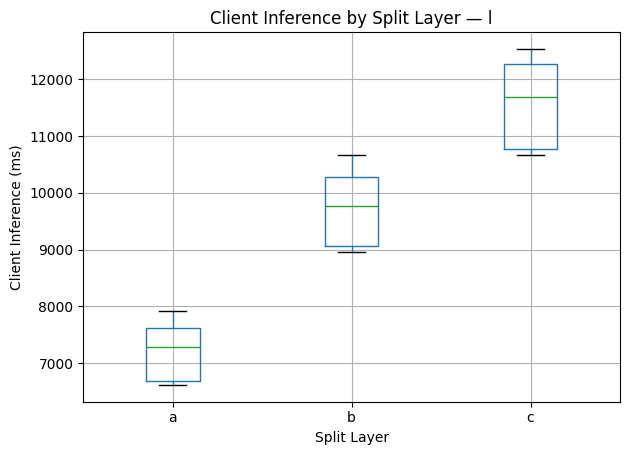

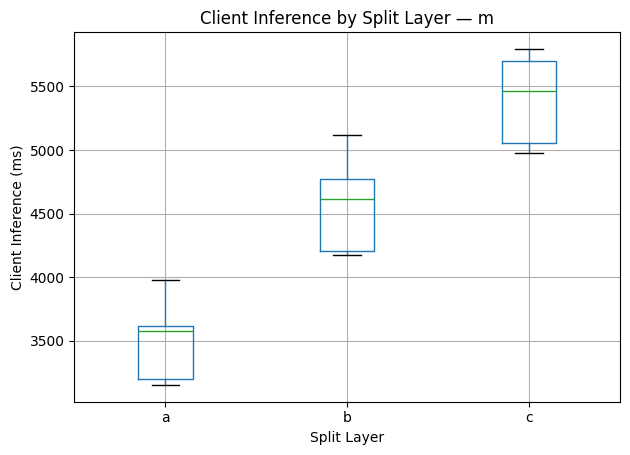

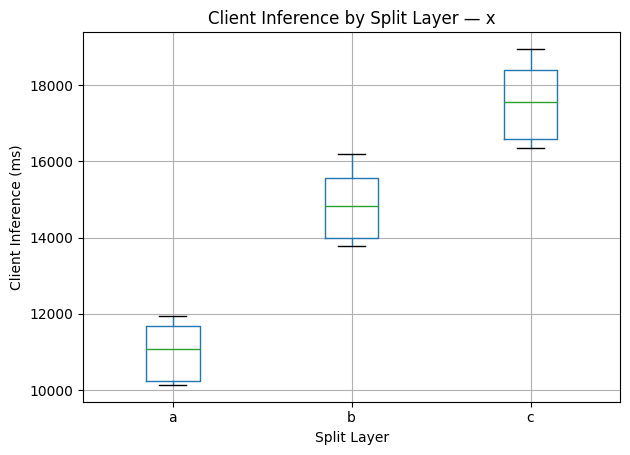

In [20]:
import pandas as pd
import matplotlib.pyplot as plt

for model, df in combined_df.groupby('model_size'):
    df.boxplot(column='client_inference_ms', by='split_layer')
    plt.title(f'Client Inference by Split Layer — {model}')
    plt.suptitle('')
    plt.xlabel('Split Layer')
    plt.ylabel('Client Inference (ms)')
    plt.tight_layout()
    plt.show()

## Average Inference and Communication Timings by Model/Split

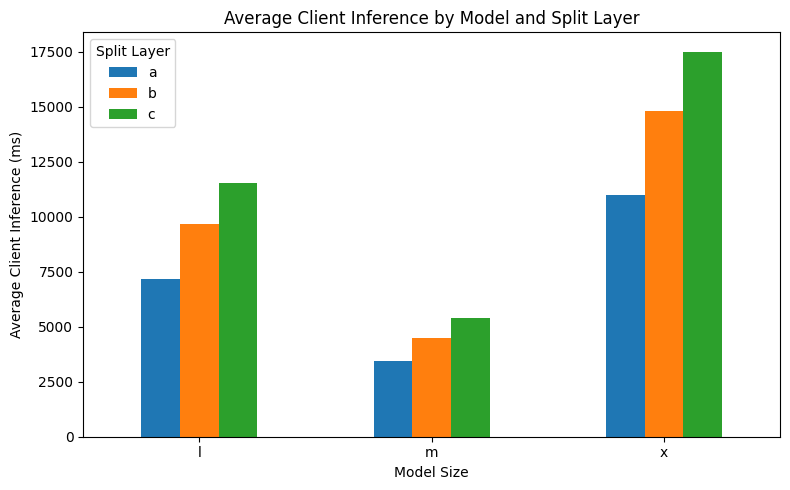

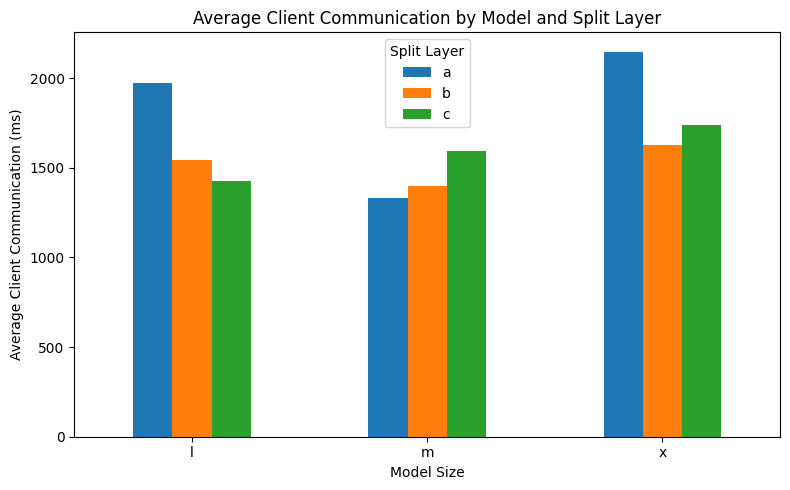

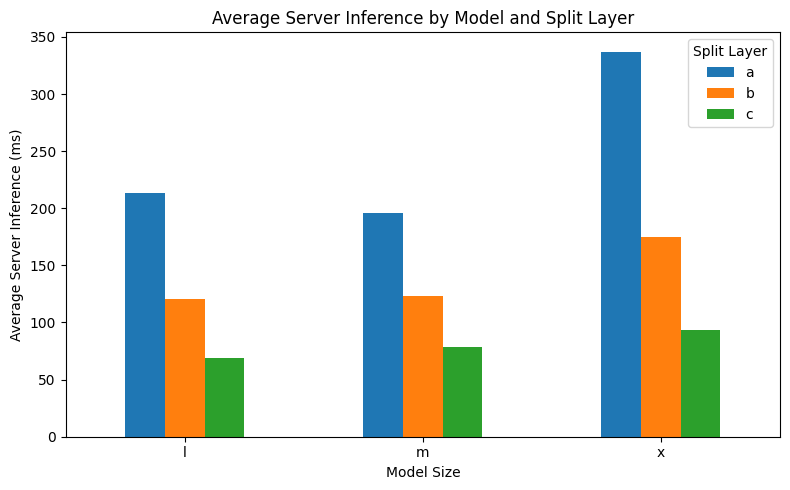

In [21]:
import matplotlib.pyplot as plt
import pandas as pd

# Compute the mean inference time per model + split
avg_df = (
    combined_df.groupby(['model_size', 'split_layer'])['client_inference_ms']
    .mean()
    .unstack()  # columns become split_layer
)

# Plot grouped bars
ax = avg_df.plot(kind='bar', figsize=(8, 5))
plt.title('Average Client Inference by Model and Split Layer')
plt.xlabel('Model Size')
plt.ylabel('Average Client Inference (ms)')
plt.xticks(rotation=0)
plt.legend(title='Split Layer')
plt.tight_layout()
plt.show()

# Compute the mean communication time
avg_df = (
    combined_df.groupby(['model_size', 'split_layer'])['client_comm_ms']
    .mean()
    .unstack()
)

# Plot grouped bars
ax = avg_df.plot(kind='bar', figsize=(8, 5))
plt.title('Average Client Communication by Model and Split Layer')
plt.xlabel('Model Size')
plt.ylabel('Average Client Communication (ms)')
plt.xticks(rotation=0)
plt.legend(title='Split Layer')
plt.tight_layout()
plt.show()

# Compute the mean server inference time
avg_df = (
    combined_df.groupby(['model_size', 'split_layer'])['server_inference_ms']
    .mean()
    .unstack()
)

ax = avg_df.plot(kind='bar', figsize=(8, 5))
plt.title('Average Server Inference by Model and Split Layer')
plt.xlabel('Model Size')
plt.ylabel('Average Server Inference (ms)')
plt.xticks(rotation=0)
plt.legend(title='Split Layer')
plt.tight_layout()
plt.show()

In [22]:
# Generate a .csv with the average client inference, comm time and server inference
# for each model and split
avg_df = (
    combined_df.groupby(['model_size'])[['client_inference_ms', 'client_comm_ms', 'server_inference_ms']]
    .mean()
    .unstack()
)
avg_df

model_size
client_inference_ms  l              9462.904233
                     m              4440.303789
                     x             13568.285637
client_comm_ms       l              1645.526587
                     m              1440.294463
                     x              1916.338062
server_inference_ms  l               134.043773
                     m               132.277405
                     x               235.647788
dtype: float64

## Average Payload Size

model_size
l     8.13
m     6.33
x    10.16
Name: payload_size_mib, dtype: float64


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.12/dist-packages/matplotlib/pyplot.py'>

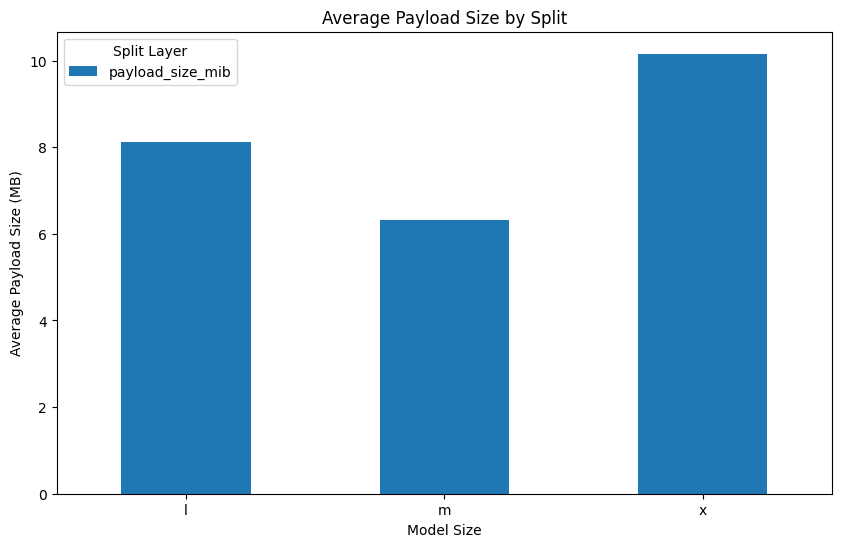

In [24]:
average_payload_size = combined_df.groupby(['model_size'])['payload_size_mib'].mean()

print(average_payload_size)

plt.figure(figsize=(10, 6))
average_payload_size.plot(kind='bar')
plt.title('Average Payload Size by Split')
plt.xlabel('Model Size')
plt.ylabel('Average Payload Size (MB)')
plt.xticks(rotation=0)
plt.legend(title='Split Layer')
plt

## Client CPU and Memory Usage

<Figure size 1000x600 with 0 Axes>

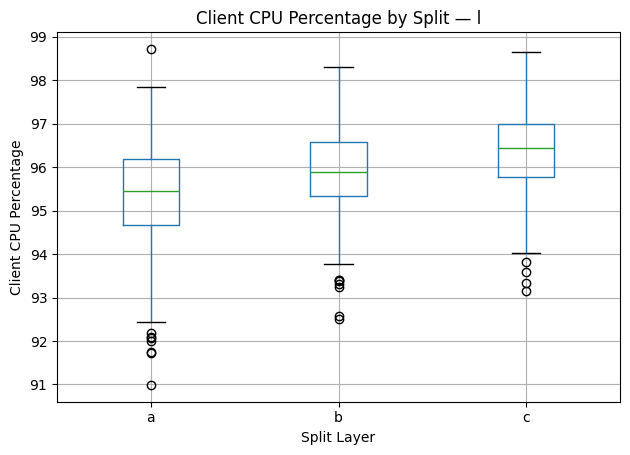

<Figure size 1000x600 with 0 Axes>

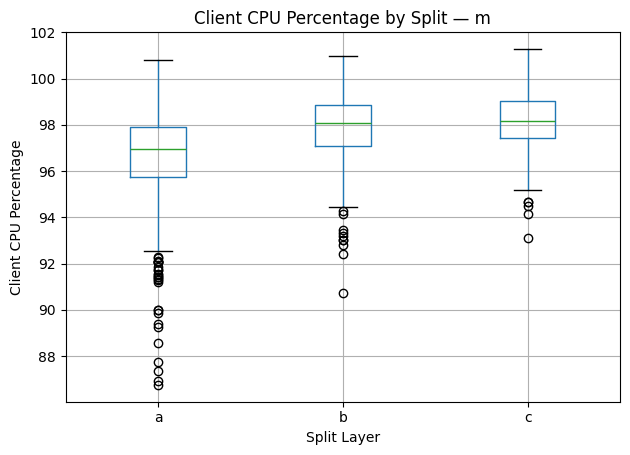

<Figure size 1000x600 with 0 Axes>

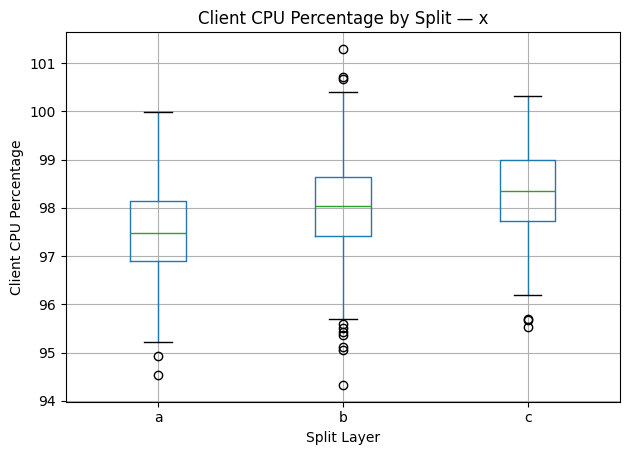

<Figure size 1000x600 with 0 Axes>

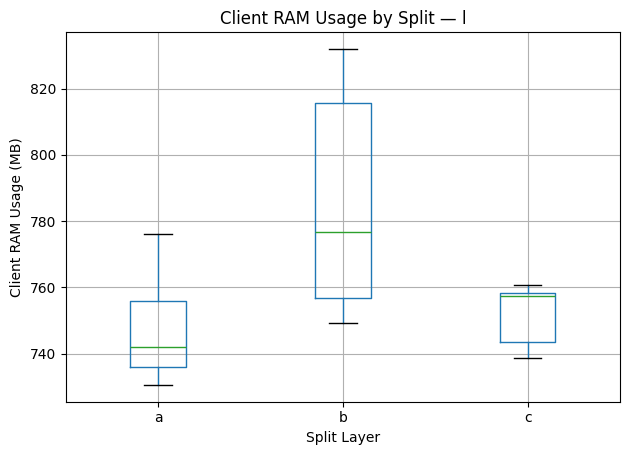

<Figure size 1000x600 with 0 Axes>

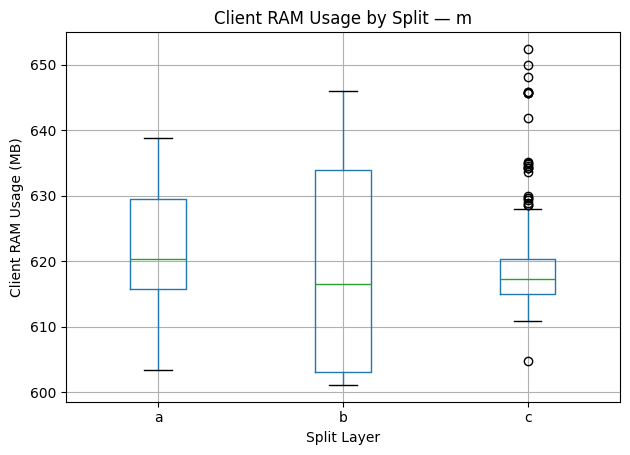

<Figure size 1000x600 with 0 Axes>

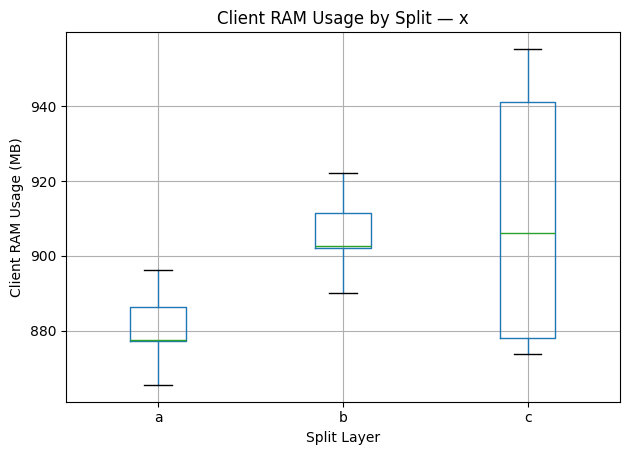

In [25]:
import matplotlib.pyplot as plt

for model, df in combined_df.groupby('model_size'):
    plt.figure(figsize=(10, 6))
    df.boxplot(column='client_cpu_perc', by='split_layer')
    plt.title(f'Client CPU Percentage by Split — {model}')
    plt.suptitle('')
    plt.xlabel('Split Layer')
    plt.ylabel('Client CPU Percentage')
    plt.tight_layout()
    plt.show()

for model, df in combined_df.groupby('model_size'):
    plt.figure(figsize=(10, 6))
    df.boxplot(column='client_ram_mb', by='split_layer')
    plt.title(f'Client RAM Usage by Split — {model}')
    plt.suptitle('')
    plt.xlabel('Split Layer')
    plt.ylabel('Client RAM Usage (MB)')
    plt.tight_layout()
    plt.show()


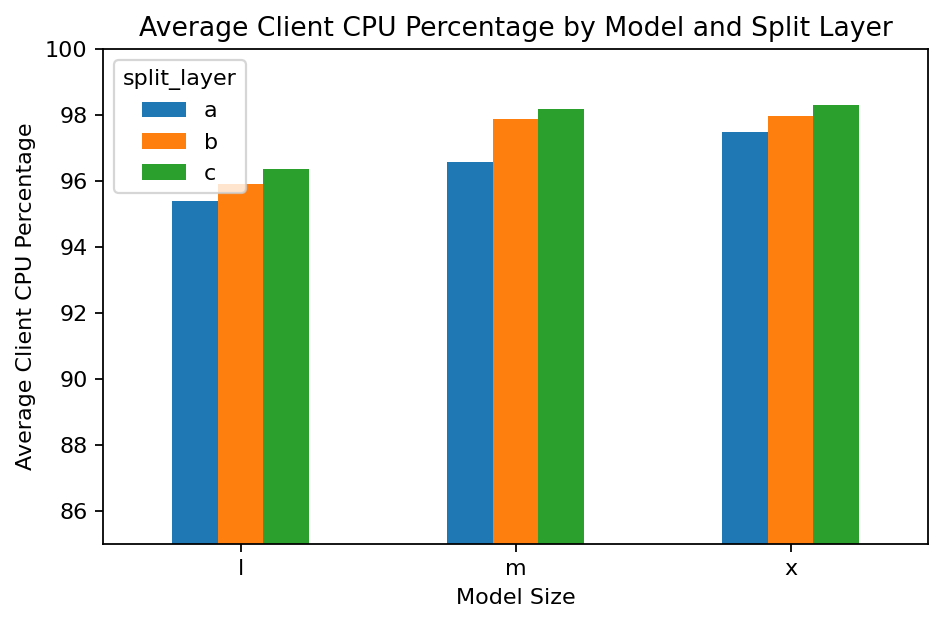

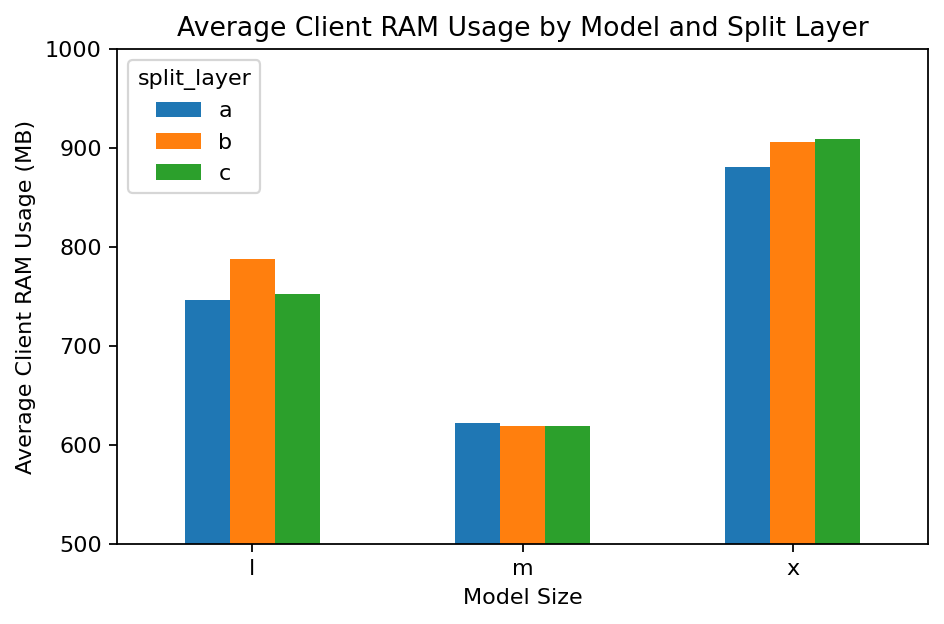

In [26]:
import matplotlib.pyplot as plt
import pandas as pd

avg_cpu = combined_df.groupby(['model_size', 'split_layer'])['client_cpu_perc'].mean().unstack()
avg_ram = combined_df.groupby(['model_size', 'split_layer'])['client_ram_mb'].mean().unstack()

# Make a clustered bar plot for avg_cpu
plt.figure(figsize=(6, 4), dpi=160)
avg_cpu.plot(kind='bar', stacked=False, ax=plt.gca())
plt.ylim(85, 100)
plt.title('Average Client CPU Percentage by Model and Split Layer')
plt.xlabel('Model Size')
plt.ylabel('Average Client CPU Percentage')
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig('avg_cpu.png')
plt.show()

# Make a clustered bar plot for avg_ram
plt.figure(figsize=(6, 4), dpi=160)
avg_ram.plot(kind='bar', stacked=False, ax=plt.gca())
plt.ylim(500, 1000)
plt.title('Average Client RAM Usage by Model and Split Layer')
plt.xlabel('Model Size')
plt.ylabel('Average Client RAM Usage (MB)')
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig('avg_ram.png')
plt.show()

## Client and Server Inference Time Series

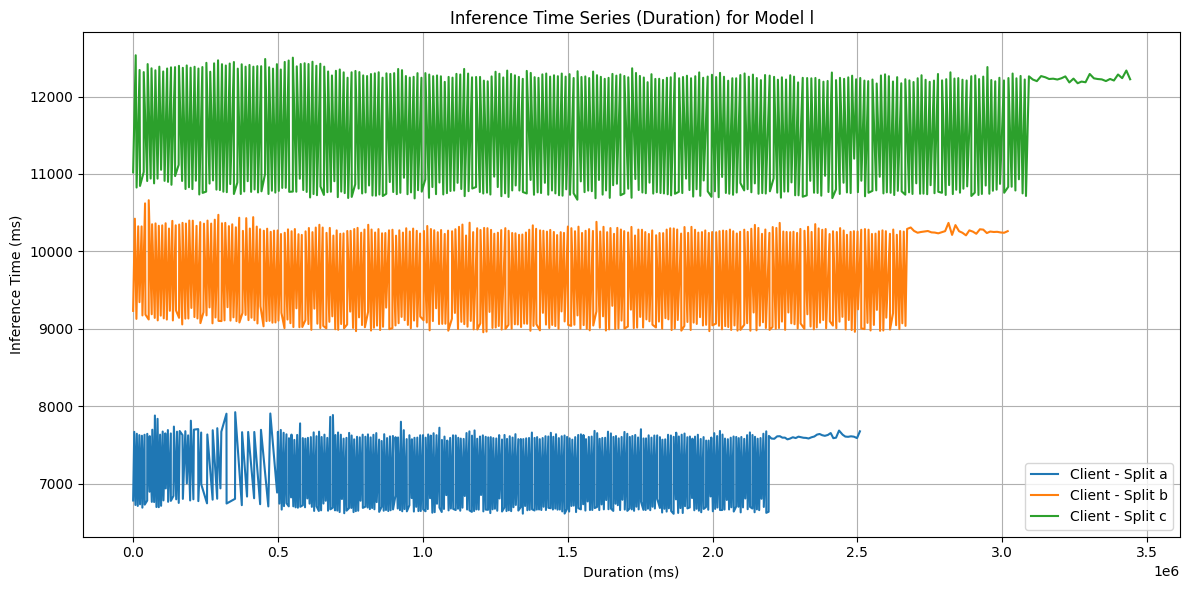

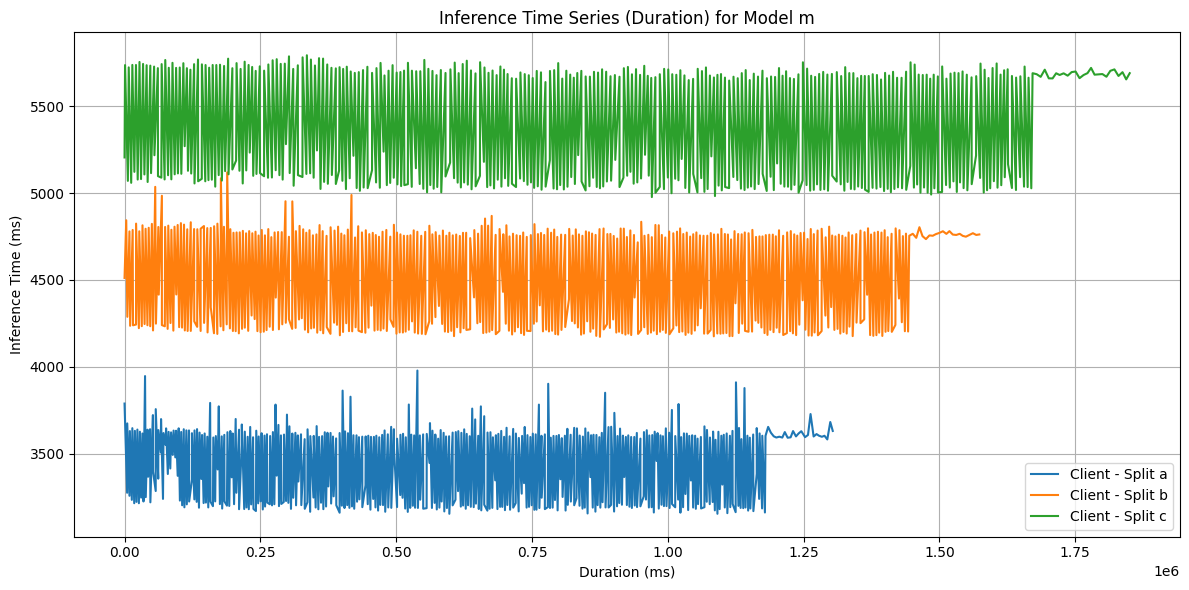

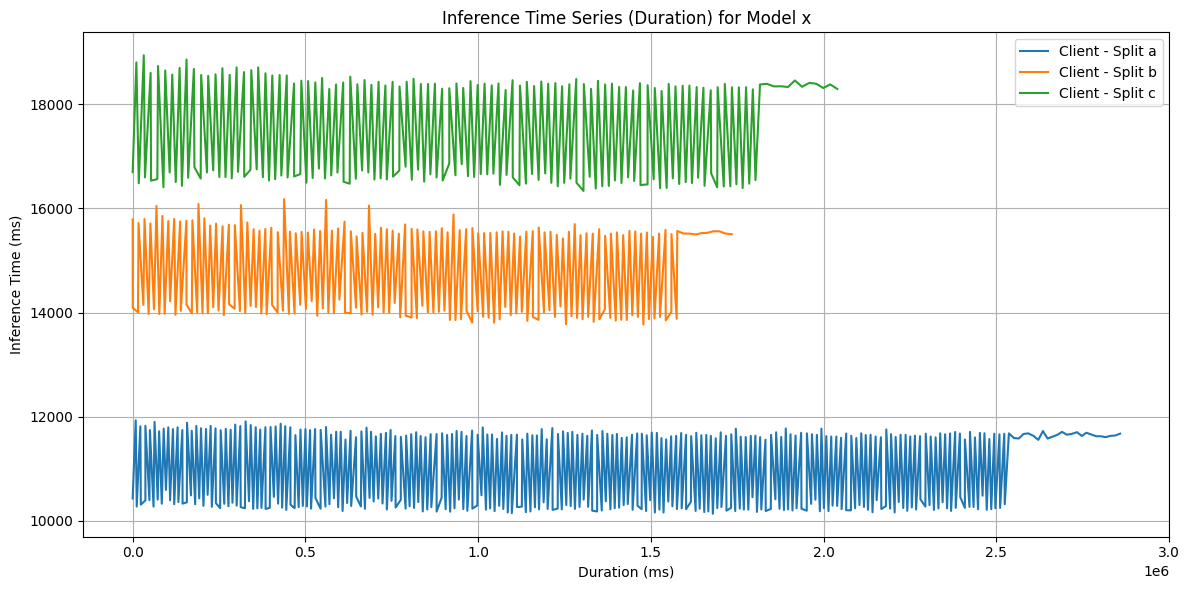

In [27]:
import matplotlib.pyplot as plt

# Convert timestamp to datetime
combined_df['timestamp'] = pd.to_datetime(combined_df['timestamp'], unit='ms')

# Sort by timestamp
combined_df = combined_df.sort_values(by='timestamp')

# Plot client and server inference time series
for model_size, model_df in combined_df.groupby('model_size'):
    plt.figure(figsize=(12, 6))
    for split_layer, split_df in model_df.groupby('split_layer'):
        # Calculate duration from the first timestamp in the split
        start_time = split_df['timestamp'].min()
        split_df['duration_ms'] = (split_df['timestamp'] - start_time).dt.total_seconds() * 1000

        plt.plot(split_df['duration_ms'], split_df['client_inference_ms'], label=f'Client - Split {split_layer}')
        #plt.plot(split_df['duration_ms'], split_df['server_inference_ms'], label=f'Server - Split {split_layer}', linestyle='--')

    plt.title(f'Inference Time Series (Duration) for Model {model_size}')
    plt.xlabel('Duration (ms)')
    plt.ylabel('Inference Time (ms)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

## Client Memory/CPU Usage Time Series

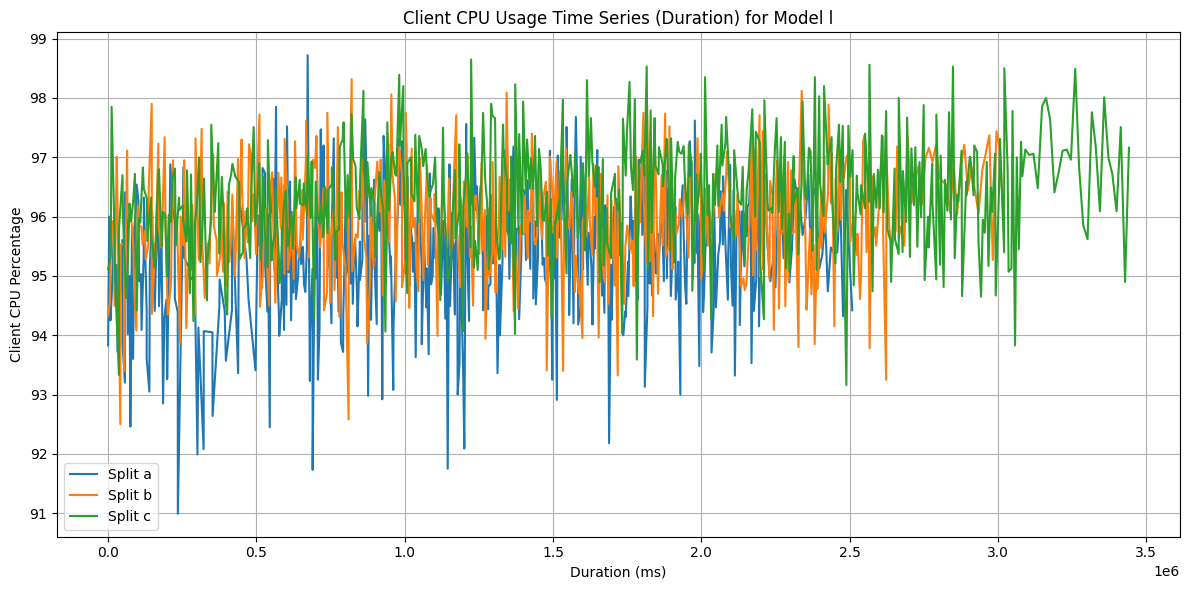

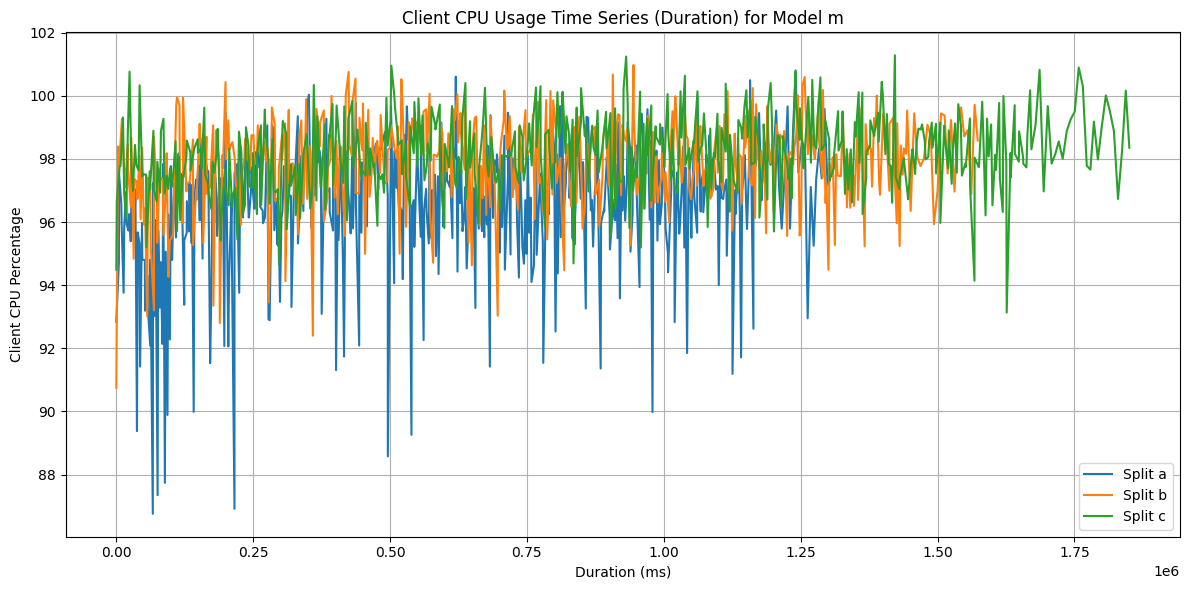

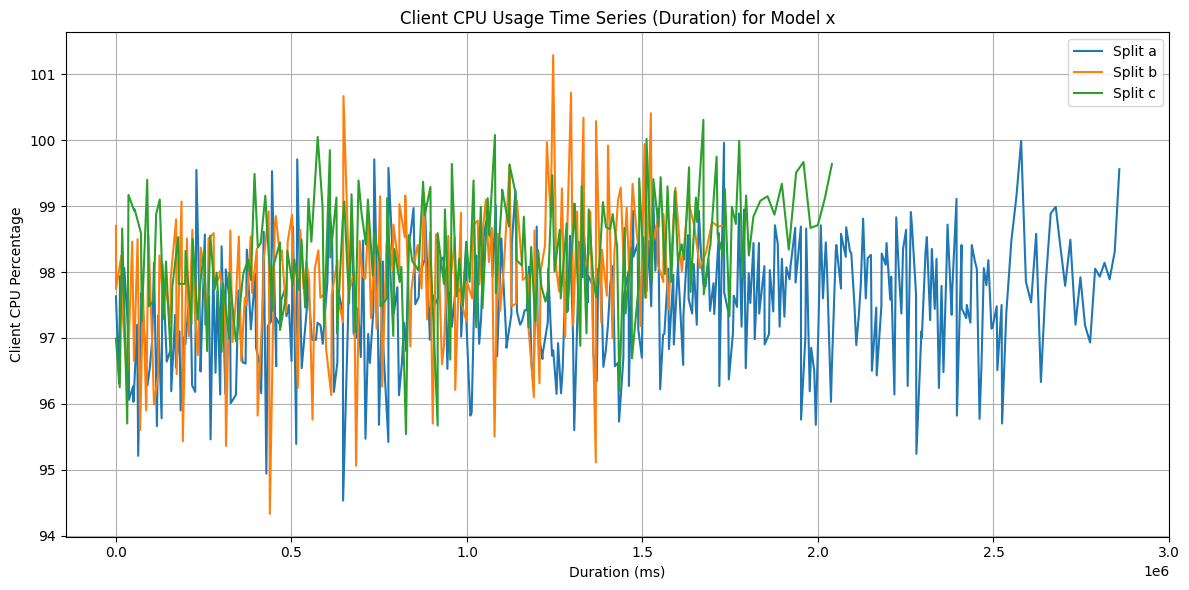

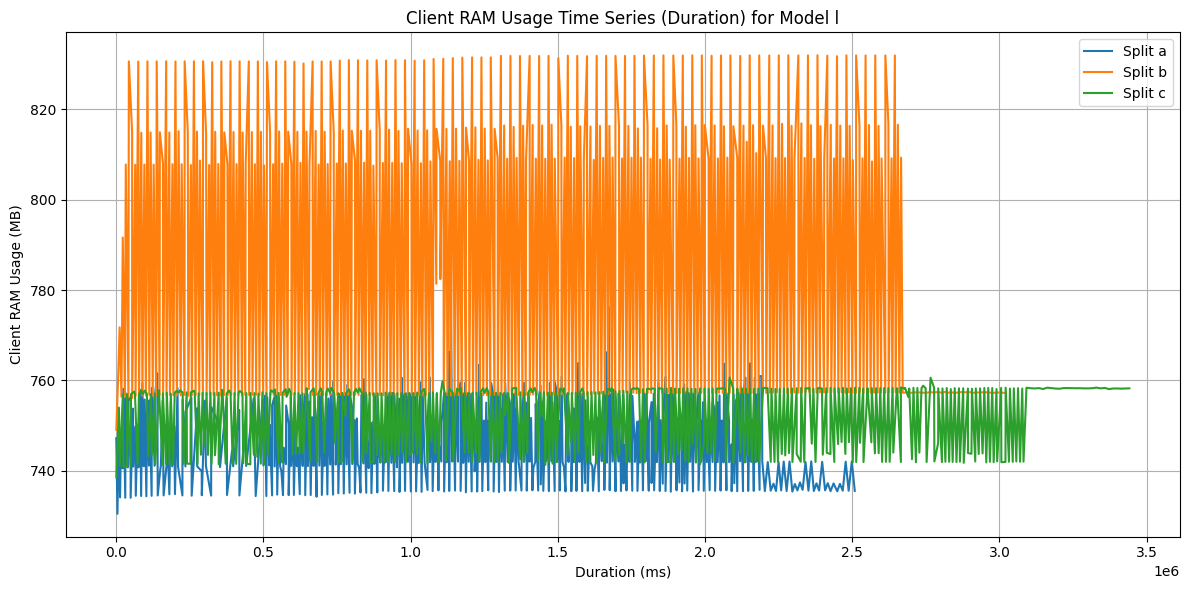

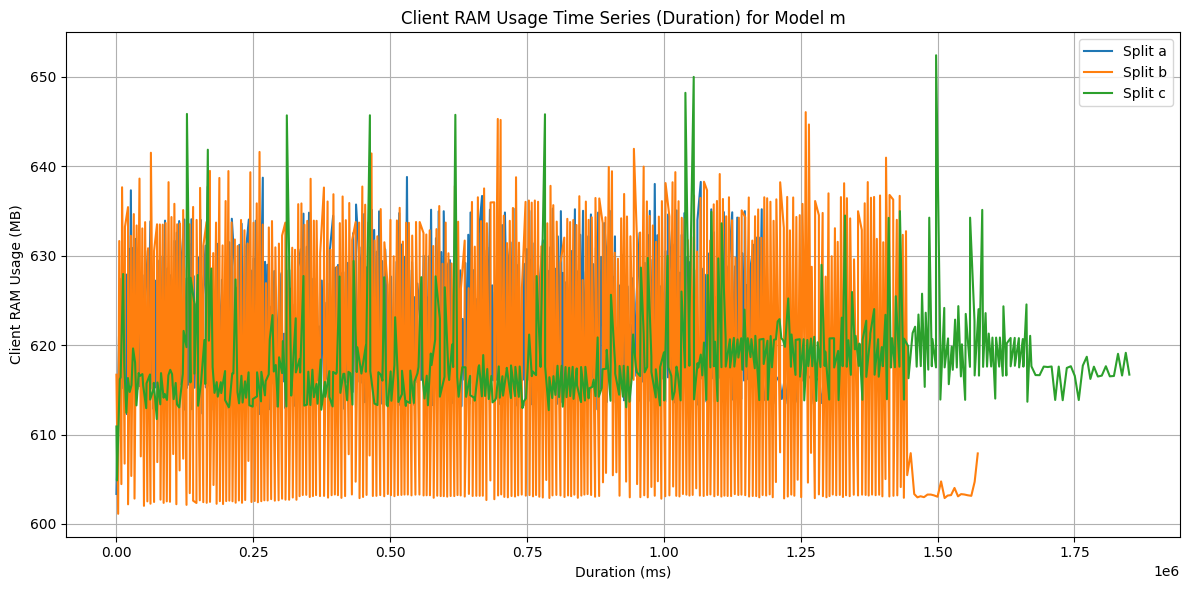

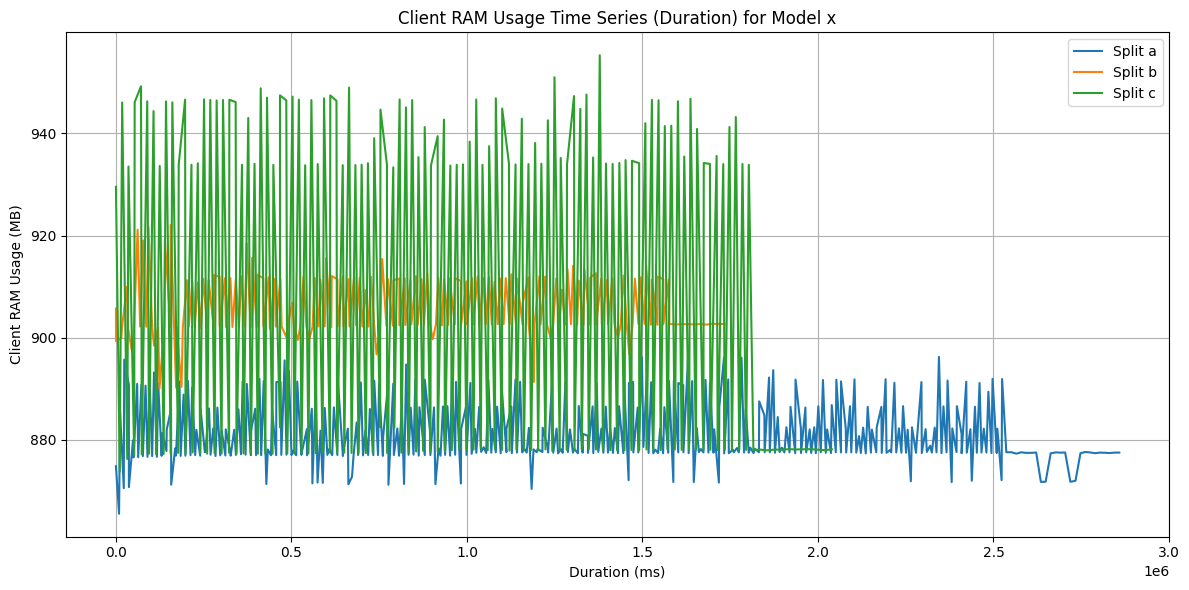

In [28]:
import matplotlib.pyplot as plt

# Convert timestamp to datetime (if not already done)
combined_df['timestamp'] = pd.to_datetime(combined_df['timestamp'], unit='ms')

# Sort by timestamp
combined_df = combined_df.sort_values(by='timestamp')

# Plot client CPU usage time series
for model_size, model_df in combined_df.groupby('model_size'):
    plt.figure(figsize=(12, 6))
    for split_layer, split_df in model_df.groupby('split_layer'):
        # Calculate duration from the first timestamp in the split (if not already done)
        start_time = split_df['timestamp'].min()
        split_df['duration_ms'] = (split_df['timestamp'] - start_time).dt.total_seconds() * 1000

        plt.plot(split_df['duration_ms'], split_df['client_cpu_perc'], label=f'Split {split_layer}')

    plt.title(f'Client CPU Usage Time Series (Duration) for Model {model_size}')
    plt.xlabel('Duration (ms)')
    plt.ylabel('Client CPU Percentage')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Plot client RAM usage time series
for model_size, model_df in combined_df.groupby('model_size'):
    plt.figure(figsize=(12, 6))
    for split_layer, split_df in model_df.groupby('split_layer'):
        # Calculate duration from the first timestamp in the split (if not already done)
        start_time = split_df['timestamp'].min()
        split_df['duration_ms'] = (split_df['timestamp'] - start_time).dt.total_seconds() * 1000

        plt.plot(split_df['duration_ms'], split_df['client_ram_mb'], label=f'Split {split_layer}')

    plt.title(f'Client RAM Usage Time Series (Duration) for Model {model_size}')
    plt.xlabel('Duration (ms)')
    plt.ylabel('Client RAM Usage (MB)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

## Average Accuracy By Model/Split

model_size
l    0.892667
m    0.955304
x    0.925000
Name: is_accurate, dtype: float64


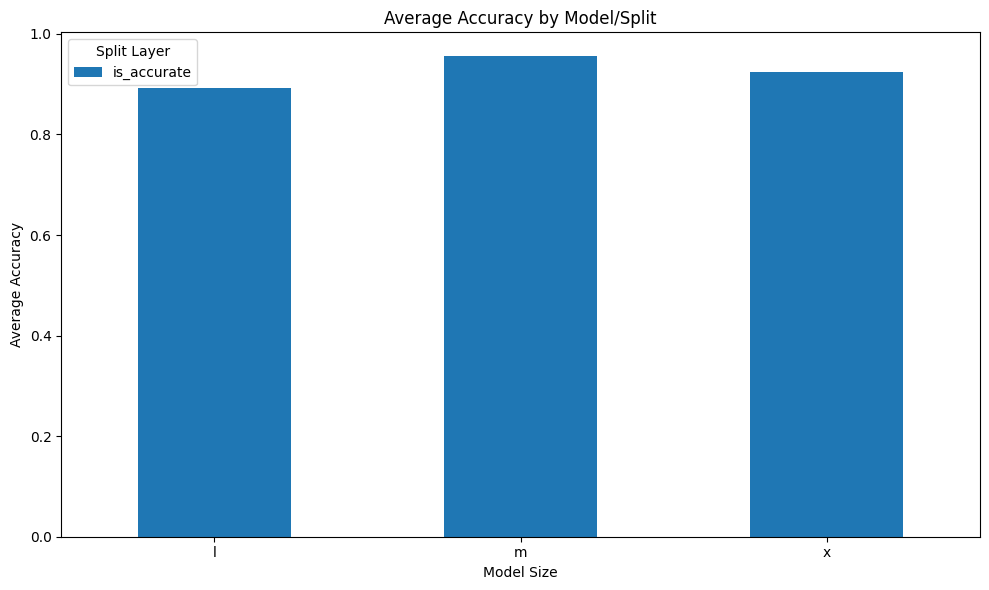

In [29]:
import pandas as pd
import matplotlib.pyplot as plt

# Merge combined_df with labels_df on 'image_name'
merged_df = pd.merge(combined_df, labels_df, on='image_name', how='left')

merged_df['is_accurate'] = (merged_df['cars_found'] == merged_df['box_count']).astype(int)

average_accuracy = merged_df.groupby('model_size')['is_accurate'].mean()
print(average_accuracy)

# Plot the average accuracy as a clustered bar plot
plt.figure(figsize=(10, 6))
average_accuracy.plot(kind='bar', ax=plt.gca()) # Use ax=plt.gca() to plot on the current figure
plt.title('Average Accuracy by Model/Split')
plt.xlabel('Model Size')
plt.ylabel('Average Accuracy')
plt.xticks(rotation=0)
plt.legend(title='Split Layer')
plt.tight_layout()
plt.show()